# Nain Sea Level Analysis

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from utide import solve

# latitude of tide gauge (needed for tidal analysis)
lat = 56.550

datadir = Path("../data/external")

## 1. Load Data

Hourly sea level data for Nain (UH#833) downloaded from [UHSLC](http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv).

In [2]:
# URL to dataset on UHSLC website
url = "http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv"

# read data into `pandas.DataFrame`
df = pd.read_csv(
    url,                                              # URL to dataset on UHSLC website
    header=None,                                      # the dataset doesn't have a header
    names=["year", "month", "day", "hour", "height"], # name columns
    na_values=-32767                                  # set invalid values to NaN
)

# convert columns with date/time information to datetime object
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df["time"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# use the datetime object as index (this will make things much easier)
df = df.set_index("time")

# remove the columns with date/time information
# (all the information is now contained in the index)
df = df.drop(["year", "month", "day", "hour"], axis=1)
df

,height
time,
1963-10-17 05:00:00,530.0
1963-10-17 06:00:00,650.0
1963-10-17 07:00:00,970.0
1963-10-17 08:00:00,1380.0
1963-10-17 09:00:00,1870.0
...,...
2018-12-31 19:00:00,1889.0
2018-12-31 20:00:00,1821.0
2018-12-31 21:00:00,1633.0


### Figure: Raw Time Series

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: UHSLC)'),
 Text(0, 0.5, 'Sea Level [mm]')]

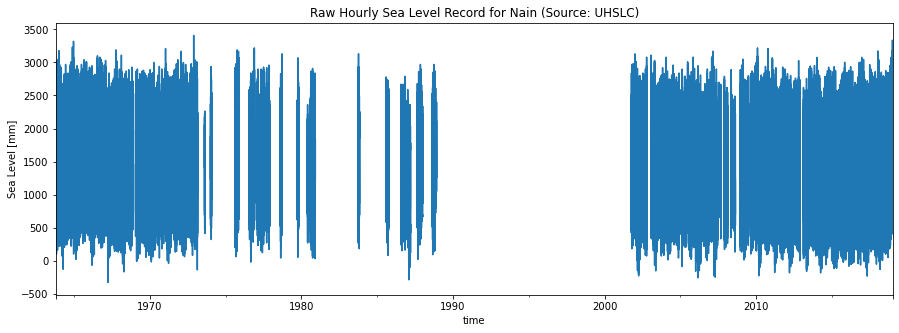

In [3]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["height"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: UHSLC)",
    ylabel="Sea Level [mm]"
)

#### From Metadata `qa833a.dmt`

**Refernce Levl:**  
All heights have been referred to the station tide staff zero which is linked to fixed benchmarks. BM 'yard' Elevation 8.680m above Chart Datum. A CHS tablet set vertically in top of rock outcrop in the Moravian Mission yard, 14m south of the SE corner of the minister's residence & 2m W of the mission boarding house.

**Benchmark relationships:**
* 1963-1981 BM 'yard' elevation 7.462m above Chart Datum
* 1981-1989 BM 'yard' elevation 8.680m above Chart Datum

**Auxiliary benchmarks:**
* 86F9000: Elevation 5.925m above Chart Datum 
* 'man hole key': Elevation 7.974m above Chart Datum

**Comment:**  
The timing has lower quality 1963-1985. Daily means compared to CMEMS altimeter suggests stable reference level 2001-2018.

### DFO Database

* The data above were collected by DFO [(Station 1430)](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=1430&user=isdm-gdsi&region=ATL#digital).
* The tidal benchmarks for this station are listed [here](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/benchmarks-reperes/station-eng.asp?T1=1430&region=ATL).
* The benchmark "YARD" mentioned in the UHSLC dataset has the Unique Number XXF9533.
* The auxiliary benchmark "86F9000" has the Unique Number no_id (benchmark condition "unstable")
* The auxiliary benchmark "man hole key" has the Unique Number no_id (benchmark condition "destroyed")
* The benchmark "97F0159" (benchmark condition "new") is 3.606m above Chart Datum and is the closest tidal benchmark with [vertical datum control](https://webapp.geod.nrcan.gc.ca/geod/data-donnees/station/report-rapport.php?id=97F0159).

### PSMSL

* Station ID [1029](https://www.psmsl.org/data/obtaining/stations/1029.php)
* A discussion of Nain data 1964-72 including possible datum shift February 1967 is in [Thompson et al. (1986)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JC091iC12p14261).
* 1963-88 gauge type=float/stilling well 1989-94 gauge= other pressure type

### SONEL
The appears to be some [vertical land movement](https://www.sonel.org/spip.php?page=gps&idStation=748), probably due to glacial isostatic adjustment

## Thompson et al. (1986)

_"The e2 series (Figure 7) shows a rather rapid  rise during 1964-1968 which is interrupted by ~10-cm drop in February 1967. It appears from the leveling history of the gage (S. Grant, personal communication, 1986) that the rise may be due to subsidence of the wharf supporting the gage; the 10-cm jump is probably related to the installation of a new gage in February 1967 which was 9 cm higher than its predecessor. Thus a significant part of the e2 variance can probably be related to instrument error."_

_"Unfortunately, a significantpart of the residual variance appears to be due to an uncorrected datum shift and localized subsidence of the gage. The remaining residual variance may be due to real changesin the strength of the Labrador Current. However, before such an interpretation is attempted, it will probably be necessary to "calibrate" the gage with further measurements of water density, current, and bottom pressure."_


[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: UHSLC)'),
 Text(0, 0.5, 'Sea Level [mm]')]

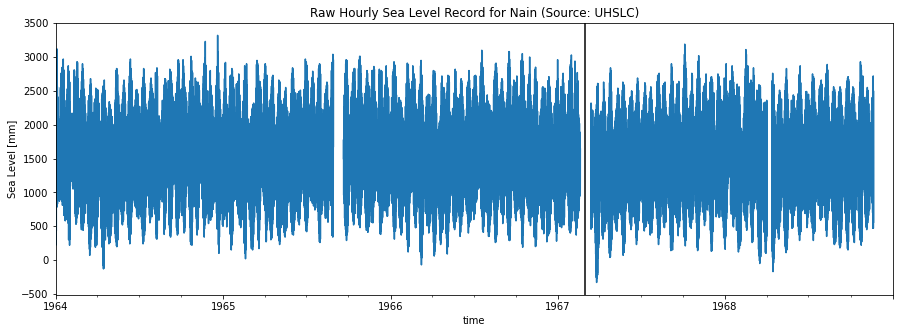

In [4]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column for the period 1964-1968
df["height"].loc["1964":"1968"].plot(
    ax=ax          # use axis `ax` created above
)

# vertical line at March 1st, 1976
ax.axvline("1967-03-01", color="k")

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: UHSLC)",
    ylabel="Sea Level [mm]"
)

## Tidal Analysis

From [UTide GitHub page](https://github.com/wesleybowman/UTide):

```
coef = solve(time, time_series_u, time_series_v,
             lat=30,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)
```

In [5]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=0.95,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"], , coef["mean"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci", ]
    )
    
    return df_out

### Tidal Analysis for 2018

Let's test our function with data for the year 2018.

In [6]:
# we select the column "height" from our `pandas.Dataframe` so it becomes
# a `pandas.Series`. Using the `.loc` function, we select the data for the
# year 2018 only. The second input parameter is the latitude of the tide
# gauge defined at the very beginning of this notebook.
tides2018 = tidal_analysis(df["height"].loc["2018"], lat)
tides2018

,A,A_ci,g,g_ci
M2,772.424922,1.528486,73.014376,0.113356
S2,274.721394,1.528313,352.763061,0.318754
N2,169.376560,1.528349,271.177207,0.516994
K1,91.791382,1.453987,190.987613,0.907592
SA,86.583839,15.365149,323.010765,10.162899
...,...,...,...,...
2MK5,0.323492,0.484251,48.078021,85.769189
ALP1,0.299006,1.453776,154.162965,278.660446
2Q1,0.232580,1.453715,66.357492,358.261896
3MK7,0.212740,0.142859,190.899898,38.472057


### Tidal Analysis for Multiple Segments

In [17]:
# pandas magic
result = df["height"].loc["2010":"2018"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()
ds

<xarray.Dataset>
Dimensions:      (time: 106, constituent: 35)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2018-12-31
  * constituent  (constituent) object '2MK5' '2MN6' '2MS6' ... 'SN4' 'UPS1'
Data variables:
    A            (time, constituent) object 1.1185938297742577 ... 4.26547862...
    A_ci         (time, constituent) object 1.9796824228584804 ... 3.31071057...
    g            (time, constituent) object 130.84315094338584 ... 208.164952...
    g_ci         (time, constituent) object 101.41148226597113 ... 44.5036908...

[Text(0.5, 1.0, 'Monthly N2 Tidal Amplitude'),
 Text(0, 0.5, 'N2 Tidal Amplitude [mm]')]

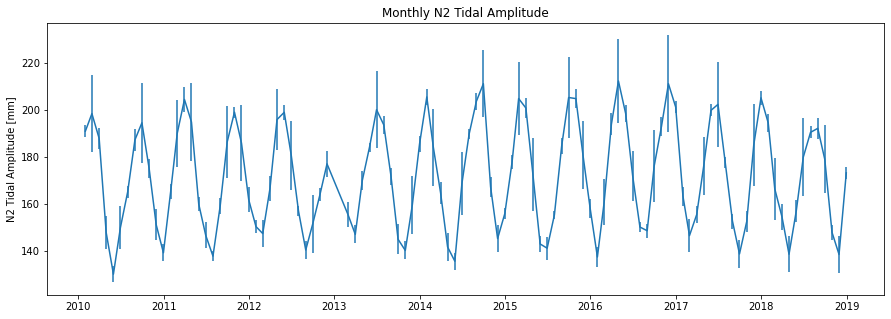

In [23]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "N2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    #fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [mm]"
)

In [27]:
# make a time variable in floating point days since a given epoch
time = mdates.date2num(df["height"].loc["2018"].index.to_pydatetime())

# use UTide to run tidal analysis
coef = solve(
    time, df["height"].loc["2018"].values,   # input variables: time and sea level as numpy arrays
    lat=lat,       # latitude of tide gauge
    nodal=False,       
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95,
    verbose=False       # no messages
)
coef

{'name': array(['M2', 'S2', 'N2', 'K1', 'SA', 'O1', 'K2', 'SSA', 'MM', 'P1', 'MSF',
        'MSM', 'NU2', '2N2', 'MU2', 'T2', 'L2', 'H2', 'H1', 'MF', 'R2',
        'M6', '2MS6', 'MKS2', 'Q1', 'J1', '2MN6', 'MS4', 'NO1', 'EPS2',
        'SIG1', 'LDA2', 'MSN2', 'S1', '2MK6', 'PSI1', 'OQ2', 'PI1', 'PHI1',
        'ETA2', '2SM6', 'MN4', 'MK3', 'RHO1', 'M4', 'TAU1', 'THE1', 'MSK6',
        'OO1', 'MO3', 'UPS1', 'MK4', 'SO3', '2SK5', 'BET1', 'CHI1', 'SO1',
        'S4', 'SN4', 'SK3', 'SK4', 'M8', '2MK5', 'ALP1', '2Q1', '3MK7',
        'M3'], dtype=object),
 'aux': {'frq': array([8.05114003e-02, 8.33333333e-02, 7.89992494e-02, 4.17807462e-02,
         1.14074111e-04, 3.87306541e-02, 8.35614924e-02, 2.28159034e-04,
         1.51215087e-03, 4.15525871e-02, 2.82193303e-03, 1.30978216e-03,
         7.92016181e-02, 7.74870986e-02, 7.76894673e-02, 8.32192592e-02,
         8.20235512e-02, 8.06254744e-02, 8.03973262e-02, 3.05009207e-03,
         8.34474074e-02, 2.41534201e-01, 2.44356134e-01, 8.07395

<AxesSubplot:xlabel='time'>

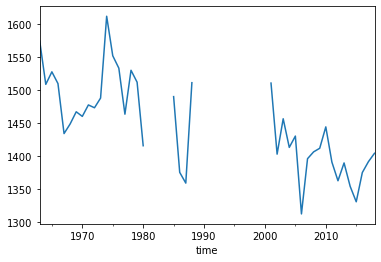

In [28]:
df["height"].groupby(pd.Grouper(freq="Y")).mean().plot()